In [1]:
import os, tqdm

In [2]:
from sklearn.metrics import r2_score
import numpy as np

# metric
def metric(label, pred):
    assert label.shape == pred.shape
    
    with np.errstate(divide = 'ignore', invalid = 'ignore'):
        mask = (label == label) & (pred == pred)
        mask = mask.astype(np.float32)
        mask /= np.mean(mask)
        
        male = np.abs(np.subtract(np.log(pred), np.log(label))).astype(np.float32)
        mae = np.abs(np.subtract(pred, label)).astype(np.float32)
        
        male = np.nan_to_num(male * mask)
        male = np.mean(male)
        
        mae = np.nan_to_num(mae * mask)
        mae = np.mean(mae)
        
        rmse = np.square(mae)
        rmse = np.nan_to_num(rmse * mask)
        rmse = np.sqrt(np.mean(rmse))
        
        mape = np.divide(mae, label)
        mape = np.nan_to_num(mape * mask)
        mape = np.median(mape*mask)
        
        print('masked:', np.sum(mask == 0))
    return male, rmse, mape

In [3]:
os.listdir('.')

['house-dataset-osm-road2vec-poa.ipynb',
 'house-dataset-feat-kde-fc-kc-poa-sp.ipynb',
 'mygeometries.py',
 'house-dataset-osm-neighbor-sp.ipynb',
 'house-dataset-osm-neighbor-kc-process.ipynb',
 '.ipynb_checkpoints',
 'brazil_data',
 'osmnx-1.3.0.zip',
 'house-dataset-feat-kde-fc-kc-poa-sp-mapviz.html',
 'house-dataset-feat-kde-fc-kc-poa-sp-mapviz.ipynb',
 'house-dataset-osm-AREA-EMBEDDING-sp.ipynb',
 'house-dataset-osm-road2vec-kc-POI-extraction.ipynb',
 'house-dataset-osm-sp-NodeEmbedding.ipynb',
 'house-dataset-osm-poa-NodeEmbedding.ipynb',
 'house-dataset-osm-AREA-EMBEDDING-kc.ipynb',
 'house-dataset-osm-road2vec-sp-POI-extraction.ipynb',
 'house-dataset-POI-sp.ipynb',
 'house-dataset-osm-neighbor-kc-process-Copy1.ipynb',
 'house-dataset-osm-kc-NodeEmbedding.ipynb',
 'osm_poi',
 'generateSE.py',
 'house-dataset-feat-kde+gaussianem_important-datagen-same-cluster.ipynb',
 'house-dataset-osm-road2vec-fc-POI-extraction.ipynb',
 'test-neighbor-mean-value.ipynb',
 'house-dataset-osm-roa

In [4]:
import numpy as np

In [5]:
streetmap = {
    'style': 'mapbox://styles/mapbox/streets-v9',
    'token': 'pk.eyJ1IjoiaHNtNjkxMSIsImEiOiJjazl0and6aDUwOWF2M2RvemdrYjllczV3In0.qGmaAF6v-1LAF9C-dnMLBg'
}
mybasemap = {
    #'style': 'mapbox://styles/mapbox/streets-v9',
    'style': 'mapbox://styles/mapbox/satellite-v9',
    'token': 'pk.eyJ1IjoiaHNtNjkxMSIsImEiOiJjazl0and6aDUwOWF2M2RvemdrYjllczV3In0.qGmaAF6v-1LAF9C-dnMLBg'
}

In [6]:
from cartoframes.viz import *

Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.


In [7]:
import pandas as pd

In [8]:
import geopandas as gpd

In [9]:
dname = 'kc'

In [10]:
print(dname)
data = np.load(f'{dname}/data.npz')

dict1 = {'lat':data['X_train'][:,0], 'lng': data['X_train'][:,1], 'price': data['y_train']}
dict2 = {'lat':data['X_test'][:,0], 'lng': data['X_test'][:,1], 'price': data['y_test']}
attr_names = []
for a in range(2, data['X_train'].shape[1]):
    dict1.update({f'attr{a-2}': data['X_train'][:, a]})
    dict2.update({f'attr{a-2}': data['X_test'][:, a]})
    attr_names.append(f'attr{a-2}')
df1 = pd.DataFrame(dict1)
df2 = pd.DataFrame(dict2)
df = pd.concat([df1, df2])

train_gdf = gpd.GeoDataFrame(df1.copy(), geometry=gpd.points_from_xy(x=df1.lng, y=df1.lat))
train_gdf.crs = 'EPSG:4326'
test_gdf = gpd.GeoDataFrame(df2.copy(), geometry=gpd.points_from_xy(x=df2.lng, y=df2.lat))
test_gdf.crs = 'EPSG:4326'
house_gdf = gpd.GeoDataFrame(df.copy(), geometry=gpd.points_from_xy(x=df.lng, y=df.lat))
house_gdf.crs = 'EPSG:4326'
#print(np.exp(df['price'].values).mean())
gdf = house_gdf
for attr in attr_names:
    print(attr, gdf[attr].nunique())
    if gdf[attr].nunique() < 30:
        gdf[attr] = gdf[attr].astype(str)
gdfcpy = gdf.copy()


#     display(Map(
#         [
#             Layer(gdfcpy, color_category_style(tattr, cat=cat, palette='cb_blues'), encode_data=False),
#             Layer(gdf, color_continuous_style('price', palette='sunset'), encode_data=False),
#         ],
#         basemap=mybasemap))

kc
attr0 13
attr1 30
attr2 1038
attr3 9782
attr4 6
attr5 2
attr6 5
attr7 5
attr8 12
attr9 946
attr10 306
attr11 116
attr12 70
attr13 70
attr14 777
attr15 8689


In [11]:
import osmnx as ox
from shapely.geometry import *

if not os.path.isdir('osmdata'):
    os.mkdir('osmdata')
    
DATASET_NAME = dname
OSM_FILE_PATH = f'osmdata/{DATASET_NAME}.graphml'

from shapely.geometry import MultiPoint


x1, y1, x2, y2 = gdf.total_bounds

house_center_latitude = (y1 + y2)/2 #sensor_hull.centroid.y
house_center_longitude = (x1 + x2)/2 #sensor_hull.centroid.x

     
graphs = dict()
# retrieve the street network for the location
if not os.path.isfile(OSM_FILE_PATH):
    center_point = gpd.GeoDataFrame(geometry = [Point(house_center_longitude, house_center_latitude)])
    center_point.crs = 'epsg:4326'
    center_point = center_point.to_crs('epsg:3310')
    max_distance = gdf.to_crs('epsg:3310').distance(center_point.iloc[0].geometry).max()+1000
    print('max_distance:', max_distance)
    graph = ox.graph_from_point((house_center_latitude, house_center_longitude), dist=max_distance)

    # save the street network to a shapefile
    ox.save_graphml(graph, filepath=OSM_FILE_PATH)
else:
    graph = ox.load_graphml(filepath=OSM_FILE_PATH)
    

# buildings = buildings.reset_index()
# buildings.geometry = buildings.geometry.centroid

In [12]:
graph2 = ox.graph_from_place('vashon')
osm_nodes2, osm_edges2 = ox.graph_to_gdfs(graph2)
osm_nodes1, osm_edges1 = ox.graph_to_gdfs(graph)


osm_nodes = pd.concat((osm_nodes1, osm_nodes2))
osm_edges = pd.concat((osm_edges1, osm_edges2))


osm_nodes['osmidn'] = osm_nodes.index
osm_nodes['osmidstr'] = osm_nodes['osmidn'].astype(str)
osm_edges = osm_edges.reset_index()
cond = np.array([str(type(s)) for s in osm_edges['highway']]) == "<class 'str'>"
osm_edges = osm_edges[cond]

In [13]:
alist = osm_nodes.geometry.tolist()

In [14]:
np.random.shuffle(alist)

In [15]:
house_gdf.unary_union

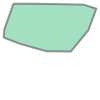

In [16]:
house_gdf.unary_union.convex_hull

In [17]:
fosm_edges = osm_edges[osm_edges.intersects(house_gdf.unary_union.convex_hull)]

In [18]:
len(set(fosm_edges['u'].unique().tolist() + fosm_edges['v'].unique().tolist()))

432827

In [19]:
fosm_node_list = list(set(fosm_edges['u'].unique().tolist() + fosm_edges['v'].unique().tolist()))

In [20]:
minx, miny, maxx, maxy = house_gdf.total_bounds + np.array([-0.01, -0.01, +0.01, +0.01])
ncols = 100
nrows = 100 #int(ncols * (maxy - miny) / (maxx - minx) * 1.2)
nwidth = (maxx - minx) / ncols
nheight = (maxy - miny) / nrows
#(maxy - miny) / (maxx - minx)

from shapely import box
geos = []
for j in range(nrows):
    for i in range(ncols):
        x1 = minx + nwidth*i
        x2 = minx + nwidth*(i+1)
        y1 = miny + nheight*j
        y2 = miny + nheight*(j+1)
        
        geos.append(box(x1, y1, x2, y2))
        
grid_gdf = gpd.GeoDataFrame(geometry=geos)

fosm_edges = osm_edges[osm_edges.intersects(box(minx, miny, maxx, maxy))]

grid_num = len(grid_gdf)

###############
import tqdm
adj_mx = np.zeros((grid_num, grid_num))
for road_geo in tqdm.tqdm(fosm_edges.geometry, total=len(fosm_edges)):
    connect_list = grid_gdf[grid_gdf.intersects(road_geo)].index
    for i in range(len(connect_list)):
        for j in range(i+1, len(connect_list)):
            ii = connect_list[i]
            jj = connect_list[j]
            adj_mx[jj, ii] += 1
            
            
##############

import node2vec
import numpy as np
import networkx as nx
from gensim.models import Word2Vec

with open(f'{dname}/Adj-grid.txt', 'w') as fp:
    for i in range(grid_num):
        for j in range(grid_num):
            if adj_mx[i, j] > 0:
                fp.write(f'{i} {j} {adj_mx[i, j]}\n')

def read_graph(edgelist):
    G = nx.read_edgelist(
        edgelist, nodetype=str, data=(('weight',float),),
        create_using=nx.DiGraph())
    return G

Adj_file = f'{dname}/Adj-grid.txt'
nx_G = read_graph(Adj_file)

num_walks = 1000
walk_length = 20
p = 1000
q = 1
is_directed = True

G = node2vec.Graph(nx_G, is_directed, p, q)
G.preprocess_transition_probs()
node2vec_walks = G.simulate_walks(num_walks, walk_length)



from gensim.models import Word2Vec

vector_size = 64
sentences = node2vec_walks
model_node = Word2Vec(sentences, window=7, min_count=0, workers=64, vector_size=vector_size)


vectors = []
for gid in range(grid_num):
    gid = str(gid)
    if gid in model_node.wv:
        vectors.append(model_node.wv[gid])
    else:
        vectors.append(np.zeros(vector_size))
vectors = np.array(vectors)
np.save(f'{dname}/grid_vectors.npy', vectors)

100%|███████████████████████████████| 1409180/1409180 [19:51<00:00, 1182.66it/s]


Walk iteration:
1 / 1000
2 / 1000
3 / 1000
4 / 1000
5 / 1000
6 / 1000
7 / 1000
8 / 1000
9 / 1000
10 / 1000
11 / 1000
12 / 1000
13 / 1000
14 / 1000
15 / 1000
16 / 1000
17 / 1000
18 / 1000
19 / 1000
20 / 1000
21 / 1000
22 / 1000
23 / 1000
24 / 1000
25 / 1000
26 / 1000
27 / 1000
28 / 1000
29 / 1000
30 / 1000
31 / 1000
32 / 1000
33 / 1000
34 / 1000
35 / 1000
36 / 1000
37 / 1000
38 / 1000
39 / 1000
40 / 1000
41 / 1000
42 / 1000
43 / 1000
44 / 1000
45 / 1000
46 / 1000
47 / 1000
48 / 1000
49 / 1000
50 / 1000
51 / 1000
52 / 1000
53 / 1000
54 / 1000
55 / 1000
56 / 1000
57 / 1000
58 / 1000
59 / 1000
60 / 1000
61 / 1000
62 / 1000
63 / 1000
64 / 1000
65 / 1000
66 / 1000
67 / 1000
68 / 1000
69 / 1000
70 / 1000
71 / 1000
72 / 1000
73 / 1000
74 / 1000
75 / 1000
76 / 1000
77 / 1000
78 / 1000
79 / 1000
80 / 1000
81 / 1000
82 / 1000
83 / 1000
84 / 1000
85 / 1000
86 / 1000
87 / 1000
88 / 1000
89 / 1000
90 / 1000
91 / 1000
92 / 1000
93 / 1000
94 / 1000
95 / 1000
96 / 1000
97 / 1000
98 / 1000
99 / 1000
100

755 / 1000
756 / 1000
757 / 1000
758 / 1000
759 / 1000
760 / 1000
761 / 1000
762 / 1000
763 / 1000
764 / 1000
765 / 1000
766 / 1000
767 / 1000
768 / 1000
769 / 1000
770 / 1000
771 / 1000
772 / 1000
773 / 1000
774 / 1000
775 / 1000
776 / 1000
777 / 1000
778 / 1000
779 / 1000
780 / 1000
781 / 1000
782 / 1000
783 / 1000
784 / 1000
785 / 1000
786 / 1000
787 / 1000
788 / 1000
789 / 1000
790 / 1000
791 / 1000
792 / 1000
793 / 1000
794 / 1000
795 / 1000
796 / 1000
797 / 1000
798 / 1000
799 / 1000
800 / 1000
801 / 1000
802 / 1000
803 / 1000
804 / 1000
805 / 1000
806 / 1000
807 / 1000
808 / 1000
809 / 1000
810 / 1000
811 / 1000
812 / 1000
813 / 1000
814 / 1000
815 / 1000
816 / 1000
817 / 1000
818 / 1000
819 / 1000
820 / 1000
821 / 1000
822 / 1000
823 / 1000
824 / 1000
825 / 1000
826 / 1000
827 / 1000
828 / 1000
829 / 1000
830 / 1000
831 / 1000
832 / 1000
833 / 1000
834 / 1000
835 / 1000
836 / 1000
837 / 1000
838 / 1000
839 / 1000
840 / 1000
841 / 1000
842 / 1000
843 / 1000
844 / 1000
845 / 1000

PROGRESS: at sentence #690000, processed 8858701 words, keeping 7976 word types
PROGRESS: at sentence #700000, processed 8986800 words, keeping 7976 word types
PROGRESS: at sentence #710000, processed 9115488 words, keeping 7976 word types
PROGRESS: at sentence #720000, processed 9243738 words, keeping 7976 word types
PROGRESS: at sentence #730000, processed 9371970 words, keeping 7976 word types
PROGRESS: at sentence #740000, processed 9500723 words, keeping 7976 word types
PROGRESS: at sentence #750000, processed 9628340 words, keeping 7976 word types
PROGRESS: at sentence #760000, processed 9756936 words, keeping 7976 word types
PROGRESS: at sentence #770000, processed 9886225 words, keeping 7976 word types
PROGRESS: at sentence #780000, processed 10014746 words, keeping 7976 word types
PROGRESS: at sentence #790000, processed 10142142 words, keeping 7976 word types
PROGRESS: at sentence #800000, processed 10269989 words, keeping 7976 word types
PROGRESS: at sentence #810000, proces

PROGRESS: at sentence #1700000, processed 21818503 words, keeping 7976 word types
PROGRESS: at sentence #1710000, processed 21947686 words, keeping 7976 word types
PROGRESS: at sentence #1720000, processed 22076710 words, keeping 7976 word types
PROGRESS: at sentence #1730000, processed 22203664 words, keeping 7976 word types
PROGRESS: at sentence #1740000, processed 22332229 words, keeping 7976 word types
PROGRESS: at sentence #1750000, processed 22461173 words, keeping 7976 word types
PROGRESS: at sentence #1760000, processed 22589712 words, keeping 7976 word types
PROGRESS: at sentence #1770000, processed 22717759 words, keeping 7976 word types
PROGRESS: at sentence #1780000, processed 22846276 words, keeping 7976 word types
PROGRESS: at sentence #1790000, processed 22974372 words, keeping 7976 word types
PROGRESS: at sentence #1800000, processed 23103100 words, keeping 7976 word types
PROGRESS: at sentence #1810000, processed 23231225 words, keeping 7976 word types
PROGRESS: at sen

PROGRESS: at sentence #2700000, processed 34656304 words, keeping 7976 word types
PROGRESS: at sentence #2710000, processed 34784423 words, keeping 7976 word types
PROGRESS: at sentence #2720000, processed 34912856 words, keeping 7976 word types
PROGRESS: at sentence #2730000, processed 35040804 words, keeping 7976 word types
PROGRESS: at sentence #2740000, processed 35169049 words, keeping 7976 word types
PROGRESS: at sentence #2750000, processed 35296732 words, keeping 7976 word types
PROGRESS: at sentence #2760000, processed 35425622 words, keeping 7976 word types
PROGRESS: at sentence #2770000, processed 35554018 words, keeping 7976 word types
PROGRESS: at sentence #2780000, processed 35681944 words, keeping 7976 word types
PROGRESS: at sentence #2790000, processed 35809769 words, keeping 7976 word types
PROGRESS: at sentence #2800000, processed 35937720 words, keeping 7976 word types
PROGRESS: at sentence #2810000, processed 36066316 words, keeping 7976 word types
PROGRESS: at sen

PROGRESS: at sentence #3700000, processed 47491196 words, keeping 7976 word types
PROGRESS: at sentence #3710000, processed 47619725 words, keeping 7976 word types
PROGRESS: at sentence #3720000, processed 47748199 words, keeping 7976 word types
PROGRESS: at sentence #3730000, processed 47876630 words, keeping 7976 word types
PROGRESS: at sentence #3740000, processed 48004311 words, keeping 7976 word types
PROGRESS: at sentence #3750000, processed 48132343 words, keeping 7976 word types
PROGRESS: at sentence #3760000, processed 48260997 words, keeping 7976 word types
PROGRESS: at sentence #3770000, processed 48390077 words, keeping 7976 word types
PROGRESS: at sentence #3780000, processed 48518597 words, keeping 7976 word types
PROGRESS: at sentence #3790000, processed 48646127 words, keeping 7976 word types
PROGRESS: at sentence #3800000, processed 48774715 words, keeping 7976 word types
PROGRESS: at sentence #3810000, processed 48902053 words, keeping 7976 word types
PROGRESS: at sen

PROGRESS: at sentence #4700000, processed 60325764 words, keeping 7976 word types
PROGRESS: at sentence #4710000, processed 60453309 words, keeping 7976 word types
PROGRESS: at sentence #4720000, processed 60581604 words, keeping 7976 word types
PROGRESS: at sentence #4730000, processed 60710088 words, keeping 7976 word types
PROGRESS: at sentence #4740000, processed 60838690 words, keeping 7976 word types
PROGRESS: at sentence #4750000, processed 60966607 words, keeping 7976 word types
PROGRESS: at sentence #4760000, processed 61095603 words, keeping 7976 word types
PROGRESS: at sentence #4770000, processed 61224122 words, keeping 7976 word types
PROGRESS: at sentence #4780000, processed 61351979 words, keeping 7976 word types
PROGRESS: at sentence #4790000, processed 61480056 words, keeping 7976 word types
PROGRESS: at sentence #4800000, processed 61609157 words, keeping 7976 word types
PROGRESS: at sentence #4810000, processed 61738293 words, keeping 7976 word types
PROGRESS: at sen

PROGRESS: at sentence #5700000, processed 73163862 words, keeping 7976 word types
PROGRESS: at sentence #5710000, processed 73292289 words, keeping 7976 word types
PROGRESS: at sentence #5720000, processed 73420700 words, keeping 7976 word types
PROGRESS: at sentence #5730000, processed 73548722 words, keeping 7976 word types
PROGRESS: at sentence #5740000, processed 73677479 words, keeping 7976 word types
PROGRESS: at sentence #5750000, processed 73806199 words, keeping 7976 word types
PROGRESS: at sentence #5760000, processed 73934073 words, keeping 7976 word types
PROGRESS: at sentence #5770000, processed 74062994 words, keeping 7976 word types
PROGRESS: at sentence #5780000, processed 74190675 words, keeping 7976 word types
PROGRESS: at sentence #5790000, processed 74319807 words, keeping 7976 word types
PROGRESS: at sentence #5800000, processed 74447775 words, keeping 7976 word types
PROGRESS: at sentence #5810000, processed 74575486 words, keeping 7976 word types
PROGRESS: at sen

PROGRESS: at sentence #6700000, processed 86002584 words, keeping 7976 word types
PROGRESS: at sentence #6710000, processed 86131476 words, keeping 7976 word types
PROGRESS: at sentence #6720000, processed 86259823 words, keeping 7976 word types
PROGRESS: at sentence #6730000, processed 86388761 words, keeping 7976 word types
PROGRESS: at sentence #6740000, processed 86517696 words, keeping 7976 word types
PROGRESS: at sentence #6750000, processed 86645687 words, keeping 7976 word types
PROGRESS: at sentence #6760000, processed 86774746 words, keeping 7976 word types
PROGRESS: at sentence #6770000, processed 86902733 words, keeping 7976 word types
PROGRESS: at sentence #6780000, processed 87030106 words, keeping 7976 word types
PROGRESS: at sentence #6790000, processed 87158019 words, keeping 7976 word types
PROGRESS: at sentence #6800000, processed 87286591 words, keeping 7976 word types
PROGRESS: at sentence #6810000, processed 87415360 words, keeping 7976 word types
PROGRESS: at sen

PROGRESS: at sentence #7700000, processed 98839972 words, keeping 7976 word types
PROGRESS: at sentence #7710000, processed 98968723 words, keeping 7976 word types
PROGRESS: at sentence #7720000, processed 99096375 words, keeping 7976 word types
PROGRESS: at sentence #7730000, processed 99223919 words, keeping 7976 word types
PROGRESS: at sentence #7740000, processed 99352259 words, keeping 7976 word types
PROGRESS: at sentence #7750000, processed 99480576 words, keeping 7976 word types
PROGRESS: at sentence #7760000, processed 99609397 words, keeping 7976 word types
PROGRESS: at sentence #7770000, processed 99737899 words, keeping 7976 word types
PROGRESS: at sentence #7780000, processed 99865246 words, keeping 7976 word types
PROGRESS: at sentence #7790000, processed 99994117 words, keeping 7976 word types
PROGRESS: at sentence #7800000, processed 100122929 words, keeping 7976 word types
PROGRESS: at sentence #7810000, processed 100251182 words, keeping 7976 word types
PROGRESS: at s

EPOCH 1 - PROGRESS: at 29.49% examples, 2735543 words/s, in_qsize 127, out_qsize 0
EPOCH 1 - PROGRESS: at 32.20% examples, 2738699 words/s, in_qsize 124, out_qsize 3
EPOCH 1 - PROGRESS: at 34.98% examples, 2746634 words/s, in_qsize 127, out_qsize 0
EPOCH 1 - PROGRESS: at 37.70% examples, 2747714 words/s, in_qsize 127, out_qsize 0
EPOCH 1 - PROGRESS: at 40.43% examples, 2750762 words/s, in_qsize 127, out_qsize 0
EPOCH 1 - PROGRESS: at 43.13% examples, 2751560 words/s, in_qsize 127, out_qsize 0
EPOCH 1 - PROGRESS: at 45.99% examples, 2758351 words/s, in_qsize 127, out_qsize 0
EPOCH 1 - PROGRESS: at 48.71% examples, 2759419 words/s, in_qsize 127, out_qsize 0
EPOCH 1 - PROGRESS: at 51.42% examples, 2759602 words/s, in_qsize 128, out_qsize 0
EPOCH 1 - PROGRESS: at 54.12% examples, 2758362 words/s, in_qsize 126, out_qsize 1
EPOCH 1 - PROGRESS: at 56.88% examples, 2760699 words/s, in_qsize 127, out_qsize 0
EPOCH 1 - PROGRESS: at 59.55% examples, 2758851 words/s, in_qsize 128, out_qsize 0
EPOC

EPOCH 3 - PROGRESS: at 98.39% examples, 2786774 words/s, in_qsize 126, out_qsize 1
EPOCH 3: training on 102378144 raw words (102378144 effective words) took 36.6s, 2798661 effective words/s
EPOCH 4 - PROGRESS: at 2.43% examples, 2480952 words/s, in_qsize 127, out_qsize 0
EPOCH 4 - PROGRESS: at 5.27% examples, 2680518 words/s, in_qsize 126, out_qsize 1
EPOCH 4 - PROGRESS: at 8.03% examples, 2727932 words/s, in_qsize 127, out_qsize 0
EPOCH 4 - PROGRESS: at 10.76% examples, 2740564 words/s, in_qsize 127, out_qsize 0
EPOCH 4 - PROGRESS: at 13.53% examples, 2756868 words/s, in_qsize 127, out_qsize 0
EPOCH 4 - PROGRESS: at 16.32% examples, 2773400 words/s, in_qsize 125, out_qsize 2
EPOCH 4 - PROGRESS: at 19.07% examples, 2777735 words/s, in_qsize 128, out_qsize 0
EPOCH 4 - PROGRESS: at 21.89% examples, 2790901 words/s, in_qsize 127, out_qsize 0
EPOCH 4 - PROGRESS: at 24.51% examples, 2778328 words/s, in_qsize 127, out_qsize 0
EPOCH 4 - PROGRESS: at 27.12% examples, 2766988 words/s, in_qsize 

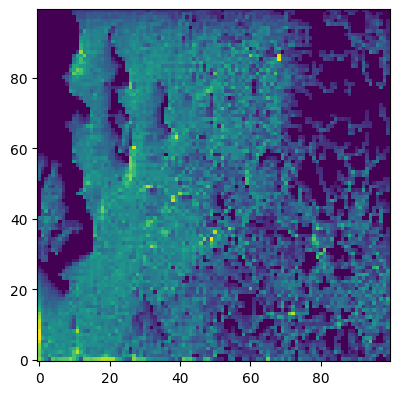

In [24]:
import numpy as np
from scipy.signal import convolve2d
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
from scipy import misc

# Load an example RGB image (you can replace this with your own image)
image = vectors.reshape(100, 100, -1)#misc.face()

# Define the standard deviation for the Gaussian kernel
sigma = 1

# Create a Gaussian kernel using scipy's gaussian_filter
gaussian_kernel = gaussian_filter(np.eye(5), sigma)

# Normalize the kernel
gaussian_kernel /= gaussian_kernel.sum()

# Initialize an empty result image with the same shape as the input image
result = np.zeros_like(image)

# Apply 2D Gaussian convolution to each color channel separately
for channel in range(vector_size):
    result[:, :, channel] = convolve2d(image[:, :, channel], gaussian_kernel, mode='same', boundary='wrap')

# Plot the original RGB image and the convolved result
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)

mag = []
for row in image.reshape(-1, vector_size):
    mag.append(np.linalg.norm(row))
mag = np.array(mag).reshape(100, 100, 1)


# plt.imshow(image.mean(-1))

plt.imshow(mag)
plt.gca().invert_yaxis()


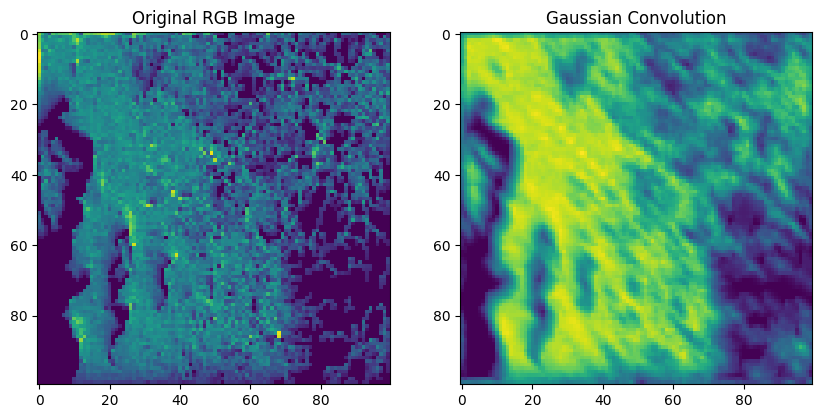

In [22]:
import numpy as np
from scipy.signal import convolve2d
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
from scipy import misc

# Load an example RGB image (you can replace this with your own image)
image = vectors.reshape(100, 100, -1)#misc.face()

# Define the standard deviation for the Gaussian kernel
sigma = 1

# Create a Gaussian kernel using scipy's gaussian_filter
gaussian_kernel = gaussian_filter(np.eye(5), sigma)

# Normalize the kernel
gaussian_kernel /= gaussian_kernel.sum()

# Initialize an empty result image with the same shape as the input image
result = np.zeros_like(image)

# Apply 2D Gaussian convolution to each color channel separately
for channel in range(vector_size):
    result[:, :, channel] = convolve2d(image[:, :, channel], gaussian_kernel, mode='same', boundary='wrap')

# Plot the original RGB image and the convolved result
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)

mag = []
for row in image.reshape(-1, vector_size):
    mag.append(np.linalg.norm(row))
mag = np.array(mag).reshape(100, 100, 1)


# plt.imshow(image.mean(-1))
plt.imshow(mag)
plt.title('Original RGB Image')

mag = []
for row in result.reshape(-1, vector_size):
    mag.append(np.linalg.norm(row))
mag = np.array(mag).reshape(100, 100, 1)


plt.subplot(1, 2, 2)
plt.imshow(mag)
plt.title('Gaussian Convolution')

plt.show()
np.save(f'{dname}/grid_vectors_gaussian.npy', result.reshape(-1, vector_size))